<a href="https://colab.research.google.com/github/jcdevaney/pyAMPACTtutorials/blob/main/01-pyAMPACT_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>pyAMPACT Introduction</h1>

In [1]:
!git clone https://github.com/jcdevaney/pyAMPACTtutorials.git
from IPython.utils import io
print('Importing libraries...')
with io.capture_output() as captured:
    !pip install --upgrade pandas
    !pip install -i https://test.pypi.org/simple/ --no-deps pyampact==0.4.0
    import pyampact
import pandas as pd
import numpy as np
import librosa

Cloning into 'pyAMPACTtutorials'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 181 (delta 74), reused 94 (delta 16), pack-reused 0
Receiving objects: 100% (181/181), 16.85 MiB | 20.06 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Importing libraries...


Load audio and symbolic files. Audio files can be any format supported by librosa (wav, mp3, flac, ogg, etc.) and symbolic files can be any format supported by music21 (kern, xml, mei, midi, abc, etc.).

The audio file should be read with librosa's `load` function and the symbolic file should be read into a Score object with pyAMPACT's `Score` function.

In [2]:
audio_file = '/content/pyAMPACTtutorials/test_files/Mozart_K179_seg.wav'
midi_file = '/content/pyAMPACTtutorials/test_files/Mozart_K179_seg.krn'

y, original_sr = librosa.load(audio_file)

piece = pyampact.Score(midi_file)


	Detected and imported these spine types:
		 function harm 



DO WE WANT TO KEEP THE OPTION TO PUT IN NEW MEANS/COVARS OR SHOULD WE JUST HARDCODE THEM? IN EITHER CASE WE PROBABLY DON'T WANT THIS IN THE ALPHA RELEASE WHERE WE ARE JUST DOING DTW.

Load default means and covariances for alignment refinement (these can be replaced with instrument specific ones)

In [3]:
means = pd.read_csv('/content/pyAMPACTtutorials/test_files/means.csv', sep=' ').values
covars = pd.read_csv('/content/pyAMPACTtutorials/test_files/covars.csv', sep=' ').values

Run the alignment with pyampact's `run_alignment` function.

You can specify the target sample rate (target_sr), window size in milliseconds (win_ms), the hop size (hop_length) as well as arguments that dictate the way that the symbolic file is represented as a spectrogram-like mask: the bin width of each note/harmonic (width) and the number of harmonics (n_harm).

CAN WE REMOVE THE PRINT-OUTS AND AUTOMATIC VISUALIZATION IN RUN_ALIGNMENT?

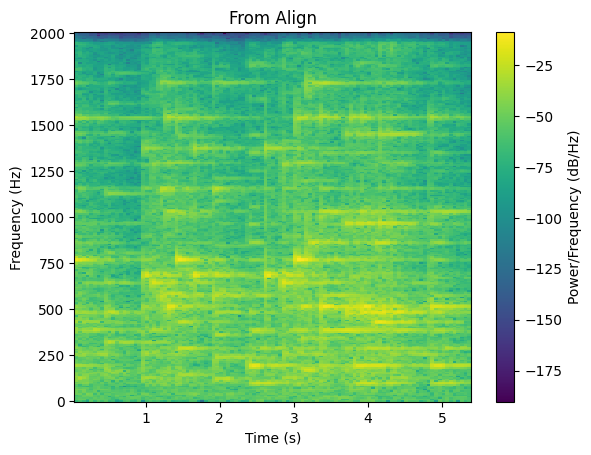

In [4]:
target_sr = 4000
win_ms = 100
hop_length = 32
width = 3
n_harm = 3

res, dtw, spec, nmat = pyampact.run_alignment(
    y, original_sr, piece, means, covars, width, target_sr, n_harm, win_ms, hop_length)

Visualize the alignment

In [5]:
times = []
freqs = []
pyampact.alignment_visualiser(spec, times, freqs, 1)

<Figure size 640x480 with 0 Axes>

Estimate performance paramters.

In this example we are estimating F0 and power values for each note. See XXX notebook for examples of all of the performance parameters that can be estimated by pyAMPACT.

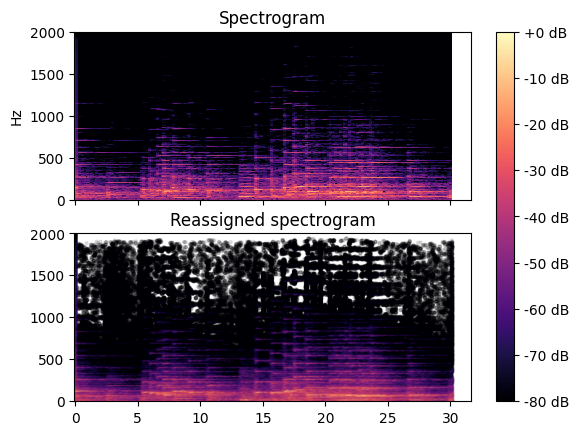

In [6]:
# Calculate an instananeous frequency-gram of the audio signal
freqs, times, mags, f0_values, mags_mat = pyampact.ifgram(audiofile=audio_file, tsr=target_sr, win_ms=win_ms)
mags_db = librosa.amplitude_to_db(mags, ref=np.max)

# Estimate F0 values
f0_values, sig_pwr = pyampact.calculate_f0_est(audio_file, hop_length, win_ms, target_sr)
sig_pwr = mags ** 2 # power of signal, magnitude/amplitude squared

# Prune NaN and zero values from estimated F0 and power
f0_values = f0_values[~np.isnan(f0_values)]
sig_pwr = sig_pwr[sig_pwr != 0]

Export estimated performance parameters to a .json file

In [7]:
pyampact.data_compilation(f0_values, sig_pwr, mags_mat, nmat, target_sr, hop_length, audio_file, y)

/usr/local/lib/python3.10/dist-packages/pyampact/dataCompilation.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,'ppitch1'] = perceptual_params['ppitch'][0]
/usr/local/lib/python3.10/dist-packages/pyampact/dataCompilation.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,'ppitch2'] = perceptual_params['ppitch'][1]
/usr/local/lib/python3.10/dist-packages/pyampact/dataCompilation.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

FileNotFoundError: [Errno 2] No such file or directory: './output_files/alignment_cdata_Mozart_K179_seg.json'

Export estimated performance parameters to a kern or MEI file

SHOULD BE DONE DIRECTLY FROM A MODIFIED NMAT, EXPORTING TO A JSON FILE ISN'T AS EFFICIENT IF ALL FURTHER PROCESSING OF THE DATA IS WITHIN PYTHON.